# Урок 2. Масштабирование признаков. Регуляризация. Стохастический градиентный спуск.

1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [2]:
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 0.5, coef = True, random_state = 42)

In [3]:
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

In [4]:
def plot_mse(errors_list):
    plt.figure(figsize=(16, 10))
    for errors in errors_list:
        errs = errors[1]
        plt.plot(range(len(errs)), errs, label = errors[0])

    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
def plot_w(w_list, w_true):
    plt.figure(figsize=(16, 10))
    for w in w_list:
        plt.scatter(w[:, 0], w[:, 1])
        plt.scatter(w_true[0], w_true[1], c='r')

    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.grid(True)
    plt.show()

In [6]:
def GD(X, Y, eta=0.01, max_iter=1e4, min_dist=1e-8):
    w = np.zeros(X.shape[1])
    w_list = [w.copy()]
    errors = []

    iter_num = 0
    weight_dist = np.inf

    while ( weight_dist > min_dist) and (iter_num < max_iter):
        new_w = w - 2 * eta * np.dot(X.T, (np.dot(X, w) - Y)) / Y.shape[0]

        weight_dist = np.linalg.norm(new_w - w, ord=2)

        w_list.append(new_w.copy())
        errors.append(mserror(X, new_w, Y))

        iter_num += 1
        w = new_w
        
    w_list = np.array(w_list)
    return w_list, errors

In [7]:
def SGD(X, Y, eta=0.1, max_iter=1e5, min_dist=1e-8):
    w = np.zeros(X.shape[1])
    w_list = [w.copy()]
    errors = []

    iter_num = 0
    weight_dist = np.inf

    while ( weight_dist > min_dist) and (iter_num < max_iter):
        train_ind = np.random.randint(X.shape[0])

        new_w = w - 2 * eta * np.dot(X[train_ind].T, (np.dot(X[train_ind], w) - Y[train_ind])) / Y.shape[0]

        weight_dist = np.linalg.norm(new_w - w, ord=2)

        w_list.append(new_w.copy())
        errors.append(mserror(X, new_w, Y))

        iter_num += 1
        w = new_w
        
    w_list = np.array(w_list)
    return w_list, errors

In [8]:
np.random.seed(1234)

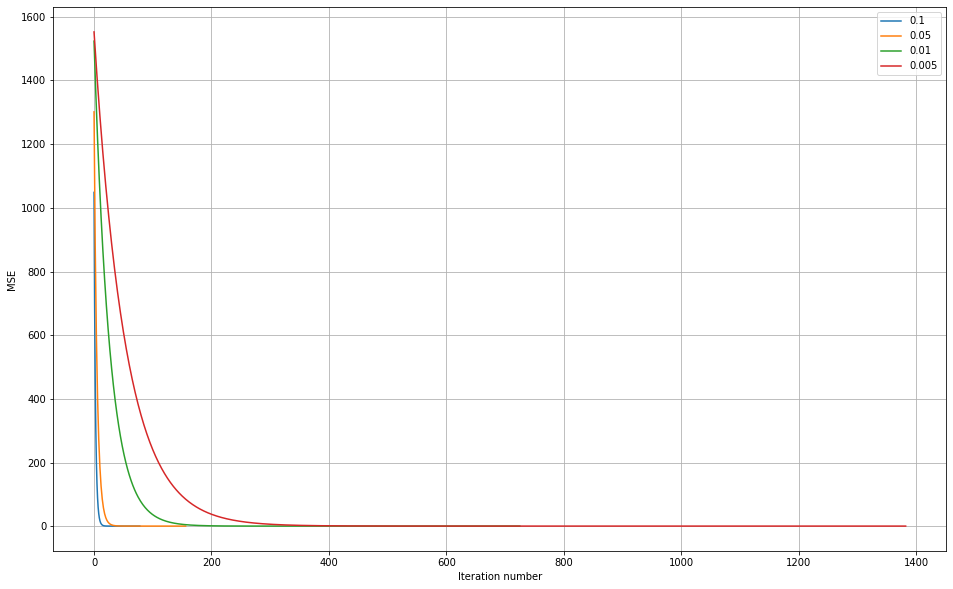

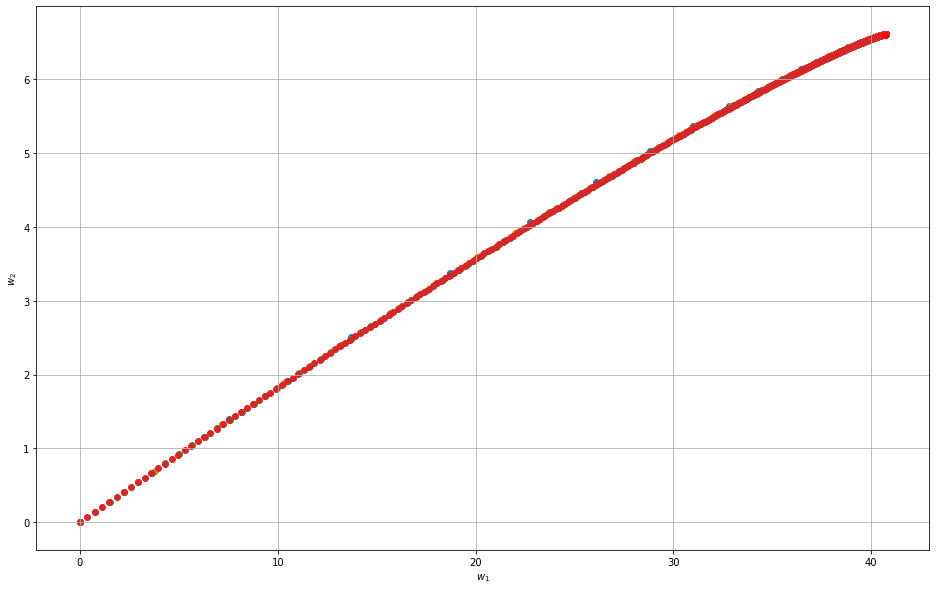

In [9]:
# Пронаблюдаем поведение алгоритма градиентного спуска при разных значениях шага eta

errors_GD_by_eta = []
w_list_GD_by_eta = []

for eta in [0.1, 0.05, 0.01, 0.005]:
    w_list_GD, errors_GD = GD(data, target, eta=eta, min_dist=1e-6)
    errors_GD_by_eta.append((str(eta), errors_GD))
    w_list_GD_by_eta.append(w_list_GD)
    
plot_mse(errors_GD_by_eta)
plot_w(w_list_GD_by_eta, coef)

В данном случае, увеличение eta не дает преимущества и результат достигнут при максимальном eta=0.1 за небольшое число итераций.
Но пришлось увеличить параметр min_dist с 1e-8 до 1e-6, т.к. в противном случае целевая точка не достигалась.

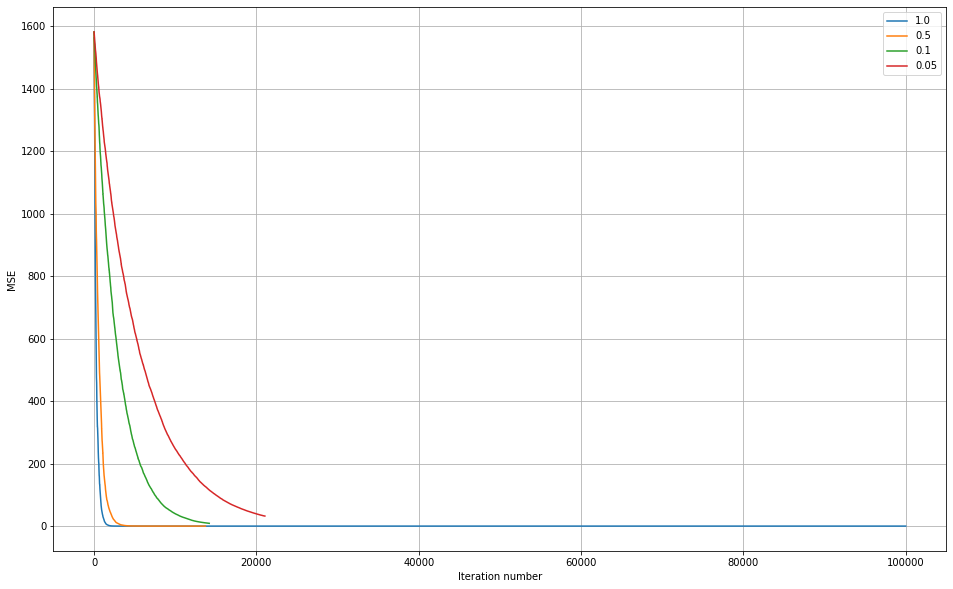

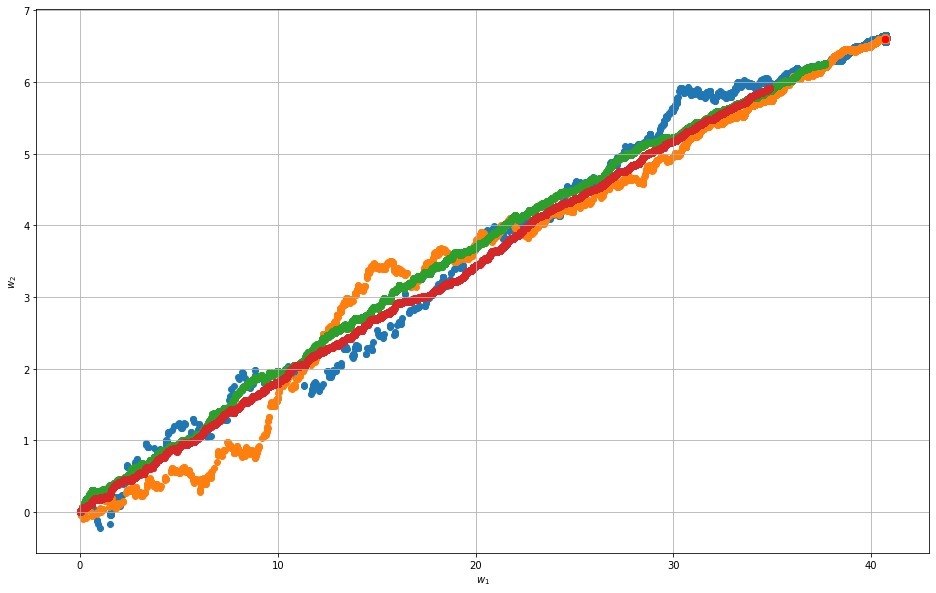

In [10]:
# Пронаблюдаем поведение алгоритма стохастичего градиентного спуска при разных значениях eta

errors_SGD_by_eta = []
w_list_SGD_by_eta = []

for eta in [1.0, 0.5, 0.1, 0.05]:
    w_list_SGD, errors_SGD = SGD(data, target, eta=eta)
    errors_SGD_by_eta.append((str(eta), errors_SGD))
    w_list_SGD_by_eta.append(w_list_SGD)
    
plot_mse(errors_SGD_by_eta)
plot_w(w_list_SGD_by_eta, coef)

Видно, что целевая точка достигнута для eta = 1.0, 0.5. При этом для eta = 0.5 потребовалось значительно меньшее количество итераций.
Кроме того, повторные запуски без изменения параметров фунции дают разные результаты. Вероятно, это связано со случайным выбором индекса данных при оценке градинета на каждой итерации.

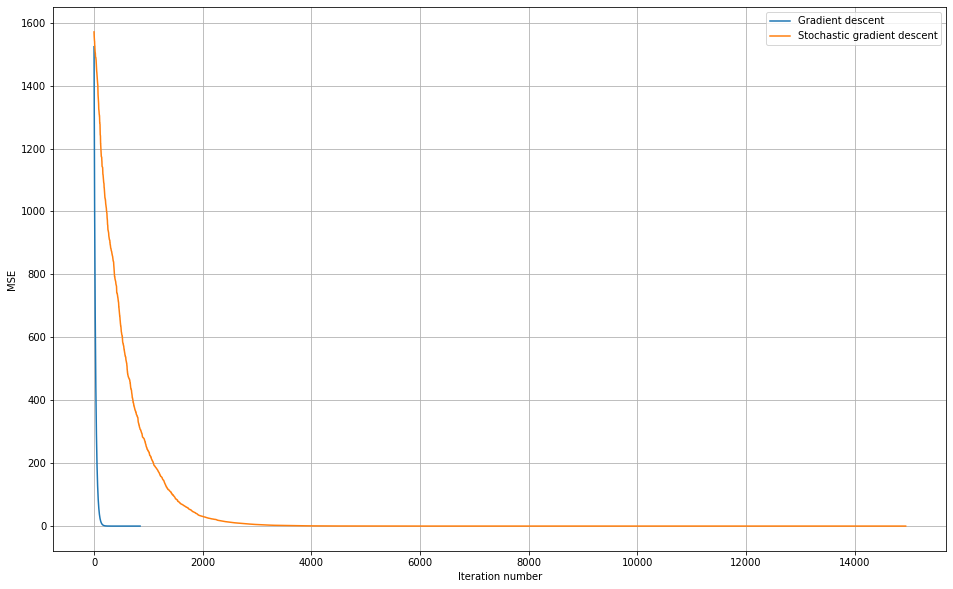

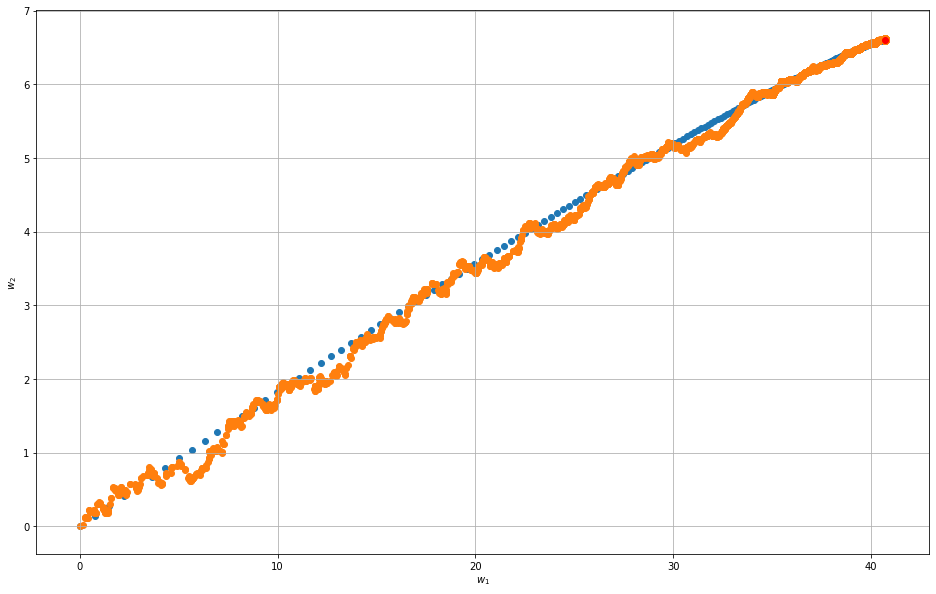

In [11]:
#  Сравнение результатов работы обоих алгоритмов

w_list_GD, errors_GD = GD(data, target, eta=0.01, min_dist=1e-7)
w_list_SGD, errors_SGD = SGD(data, target, eta=0.5, min_dist=1e-7)
plot_mse([
    ('Gradient descent', errors_GD),
    ('Stochastic gradient descent', errors_SGD)
])

plot_w([w_list_GD, w_list_SGD], coef)

In [12]:
print(f'GD MSE {round(errors_GD[-1], 4)}')
print(f'SGD MSE {round(errors_SGD[-1], 4)}')

GD MSE 0.2421
SGD MSE 0.2424


**Вывод: для стохастического градиентного спуска потребовалось большее число итераций при более крупном шаге градиента. На таком небольшом объеме данных преимущество у обычного градиентного спуска.**

2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE добавить норму весов, а в поправку нужно добавить производную для нормы вектора весов по весам) и сравнить результаты.

In [13]:
def SGD_L2(X, Y, eta=0.5, lamb=1, max_iter=1e5, min_dist=1e-7):
    w = np.zeros(X.shape[1])
    w_list = [w.copy()]
    errors = []

    iter_num = 0
    weight_dist = np.inf

    while ( weight_dist > min_dist) and (iter_num < max_iter):
        train_ind = np.random.randint(X.shape[0])
        
        X_ind_T = X[train_ind, :].T
        Q_ind = np.dot(X[train_ind, :], w) - Y[train_ind]
 
        dQ = np.dot(X_ind_T, Q_ind)
        dL2 = 2 * X_ind_T

        new_w = w - 2 * eta * (dQ + lamb*dL2) / Y.shape[0]
        
        weight_dist = np.linalg.norm(new_w - w, ord=2)
    
        w_list.append(new_w.copy())
        errors.append(mserror(X, new_w, Y))

        iter_num += 1
        w = new_w
        
    w_list = np.array(w_list)
    return w_list, errors

Вот тут "...(в функцию, считающую MSE добавить норму весов..." я совсем не поняла, зачем и в mse еще добавлять. Поэтому не добавила и, возможно, дальнейшие результаты будут некорректны.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


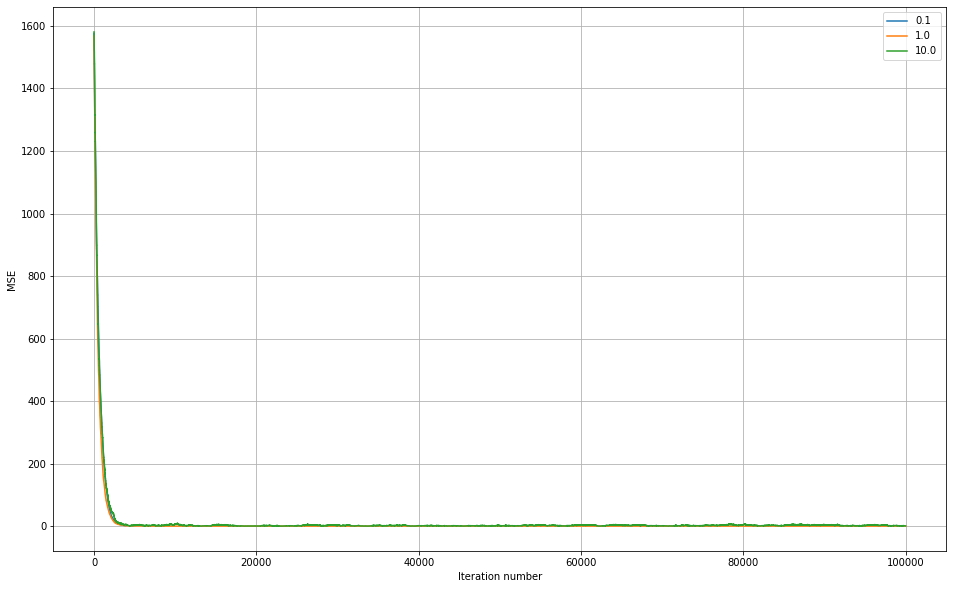

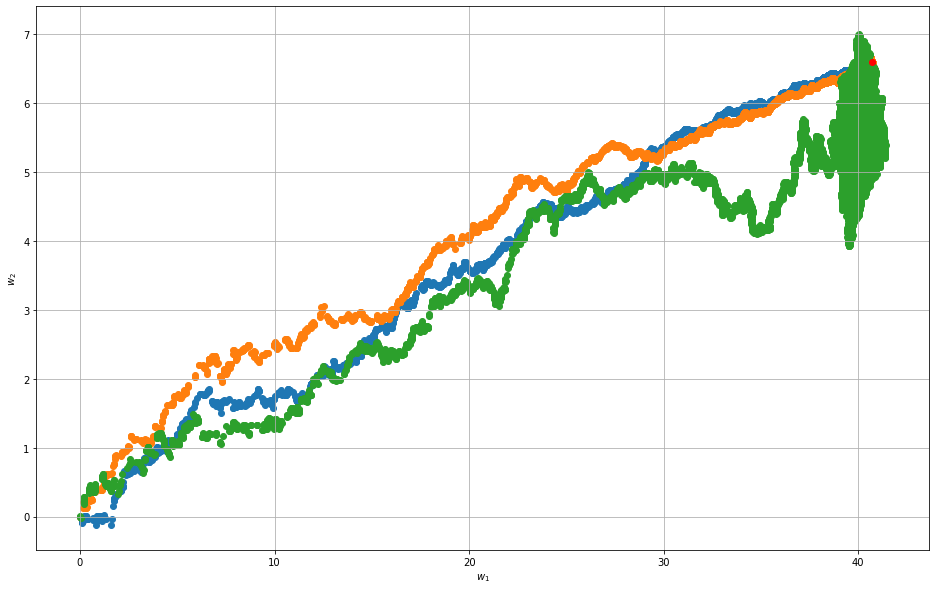

In [14]:
errors_SGD_L2_by_lamb = []
w_list_SGD_L2_by_lamb = []

for lamb in [0.1, 1.0, 10.0]:
    w_list_SGD_L2, errors_SGD_L2 = SGD_L2(data, target, lamb=lamb)
    errors_SGD_L2_by_lamb.append((str(lamb), errors_SGD_L2))
    w_list_SGD_L2_by_lamb.append(w_list_SGD_L2)
    
plot_mse(errors_SGD_L2_by_lamb)
plot_w(w_list_SGD_L2_by_lamb, coef)

SGD_L2 MSE 0.2584


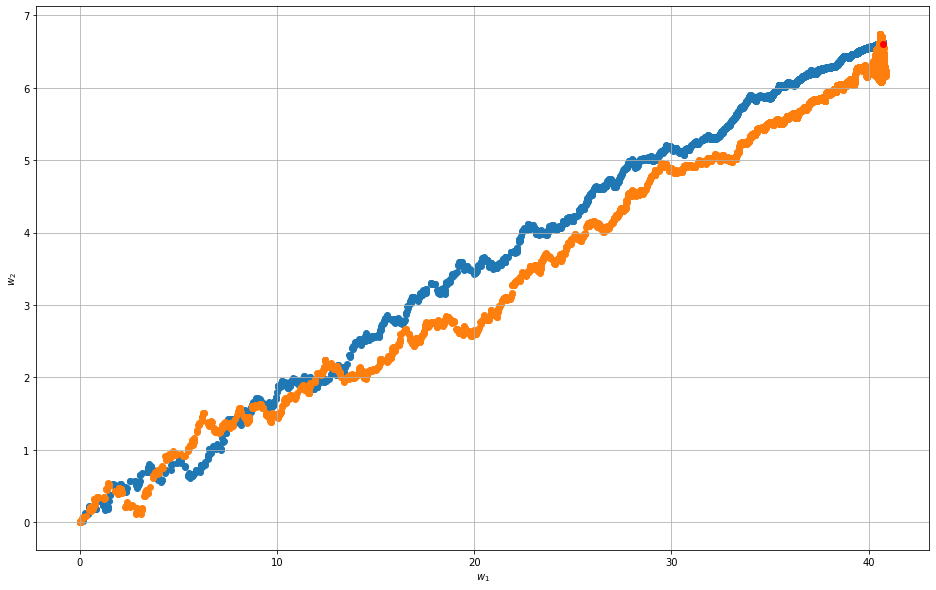

In [15]:
w_list_SGD_L2, errors_SGD_L2 = SGD_L2(data, target, lamb=2.0)

print(f'SGD_L2 MSE {round(errors_SGD_L2[-1], 4)}')

plot_w([w_list_SGD, w_list_SGD_L2], coef)

Итого MSE в алгоритме с регулизацией немного выше, заметно также, что оба коэффициента w на большинстве итераций меньше, чем без регулязации.

Т.к. регуляризация помогает бороться с переобучением, то, чтобы убедиться в эффективности алгоритма и сделать более информативные выводы, надо проделать все то же самое, но с более сложной моделью данных, разделить эти данные на тренировочные и тестовые. Затем получить w на тренировочных и сравнить результаты уже на тестовых. Но сделать это я уже не успеваю.